# [Intro to Raster Data in Python](https://www.earthdatascience.org/courses/use-data-open-source-python/intro-raster-data-python/)
# Chapter 4 Raster Data in Python

In this chapter we wil learn how to use the package **rasterio** combined with **numpy** and **earthpy** to open, manipulate and plot raster data.

We will learn about the key attributes of raster data:

1. Spatial resolution
1. Spatial extent and
1. Coordinate reference systems

## Intro to Rester Data

### What is a Raster
Raster or “gridded” data are stored as a grid of values which are rendered on a map as pixels. Each pixel value represents an area on the Earth’s surface. A raster file is composed of regular grid of cells, all of which are the same size.

We’ve looked at and used rasters before if we’ve looked at photographs or imagery in a tool like Google Earth. However, the raster files that we will work with are different from photographs in that they are spatially referenced. Each pixel represents an area of land on the ground. That area is defined by the spatial resolution of the raster.

*Fun Raster Notes*

* Each cell is called a pixel.
* And each pixel represents an area on the ground.
* The resolution of the raster represents the area that each pixel represents on the ground. So, a 1 meter resolution raster, means that each pixel represents a 1 m by 1 m area on the ground.

A raster dataset can have attributes associated with it as well. For instance, in a Lidar derived digital elevation model (DEM), each cell represents an elevation value for that location on the earth. In a Lidar derived intensity image, each cell represents a Lidar intensity value or the amount of light energy returned to and recorded by the sensor.

> Note: Light Detection and Ranging (LIDAR), is a remote sensing method that uses light in the form of a pulsed laser to measure ranges (variable distances) to the Earth.
> More info: [lidar remote sensing data and the various raster data products derived from lidar data.](https://www.earthdatascience.org/courses/use-data-open-source-python/data-stories/what-is-lidar-data/)

This means that Raster data can be used to store many different types of scientific data like:

* elevation data
* canopy height models
* surface temperature
* climate model data outputs
* landuse / landcover data






In [16]:
# Import necessary packages
import os
import matplotlib.pyplot as plt
import seaborn as sns
# Use geopandas for vector data and rasterio for raster data
import geopandas as gpd
import rasterio as rio
# Plotting extent is used to plot raster & vector data together
from rasterio.plot import plotting_extent

import earthpy as et
import earthpy.plot as ep

# Prettier plotting with seaborn
sns.set(font_scale=1.5, style="white")

Digital Surface Model (DSM): Elevation at the tops of trees, buildings, etc 

Digital Terrain Model (DTM) or digital elevation model (DEM): Elevation of the earth's surface

Canopy Height Model (CHM): Actual height of trees, buildings, etc with the influence of the ground elevation removed

CHM = DSM-DTM

## Open Raster Data

### Context Managers to Open and Close Fie Connections
A context manager allows us to open the data and work with it. Within the context manager, Python makes a temporary connection to the file.

Opening and closing files using rasterio and context managers is efficient as it establishes a connection to the raster file rather than directly reading it into memory.

Once we are done opening and reading in the data, the context manager closes that connection to the file. This efficiently ensures that the file won’t be modified later in our code.

The parts of the context manaager are:

>> with rio.open('file-path-here') as file_src:
     dtm_pre_arr = dem_src.read(1, masked=True)

1. `with` statement: creates a connection to eh file. The default connection is read only, meaning that we cannot modify the file by default. This prevents us from making unintended changes to the original data.
1. `rio.open()`: will open a connection to the file with the path provided
1. `file_src`: this is a rasterio reader object that we can use to read in the actual data. We can also use this object to access the metadata for the raster file.
2. The second line of the statement is indented. Any line that is indented below the `with` statement will become part ot the context manager. 



In [17]:
# Get data and set working directory
et.data.get_data("colorado-flood")
os.chdir(os.path.join(et.io.HOME, 'earth-analytics'))

# Define relative path to file
dem_pre_path = os.path.join("data", "colorado-flood", "spatial",
                              "boulder-leehill-rd", "pre-flood", "lidar",
                              "pre_DTM.tif")

with rio.open(dem_pre_path) as src:
    # Notice here the src object is printed and returns an "open" DatasetReader object
    print(src, "\n")

# Note that the src object is now closed because it's not within the indented
# part of the context manager above
print(src)

<open DatasetReader name='colorado-flood/spatial/boulder-leehill-rd/pre-flood/lidar/pre_DTM.tif' mode='r'> 

<closed DatasetReader name='colorado-flood/spatial/boulder-leehill-rd/pre-flood/lidar/pre_DTM.tif' mode='r'>


### Exercise
We are going to use the NEON (National Ecological Observatory Network) data

In [18]:
# Get data and set working directory
et.data.get_data("colorado-flood")
os.chdir(os.path.join(et.io.HOME, 'earth-analytics'))

# Define relative path to file
dem_pre_path = os.path.join("data","colorado-flood", "spatial",
                              "boulder-leehill-rd", "pre-flood", "lidar",
                              "pre_DTM.tif")

# Open the file using a context manager ("with rio.open" statement)
with rio.open(dem_pre_path) as dem_src:
    dtm_pre_arr = dem_src.read(1)

print("Numpy Array Shape:", dtm_pre_arr.shape)
print("Object type:", type(dtm_pre_arr))

Numpy Array Shape: (2000, 4000)
Object type: <class 'numpy.ndarray'>


When we open raster data using rasterio, we are creating a numpy array. Numpy is an efficient way to work with and process raster format data. We can plot our data using earthpy `plot_bands()` which takes a numpy array as an input and generates a plot.

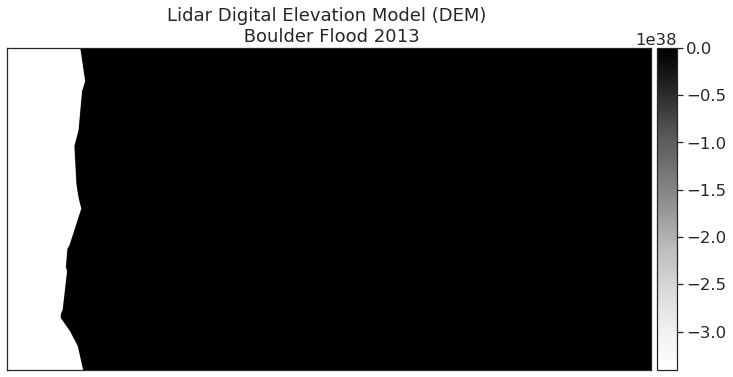

In [19]:
# Plot your data using earthpy
ep.plot_bands(dtm_pre_arr,
              title="Lidar Digital Elevation Model (DEM) \n Boulder Flood 2013",
              cmap="Greys")

plt.show()


The data above should represent terrain model data. However, the range of values is not what is expected. These data are for Boulder, Colorado where the elevation may range from 1000-3000m.

There may be some outlier values in the data that may need to be addressed. Below we check out the min and max values of the data.

the minimum raster value is:  -3.4028235e+38
the maximum raster value is:  2087.43


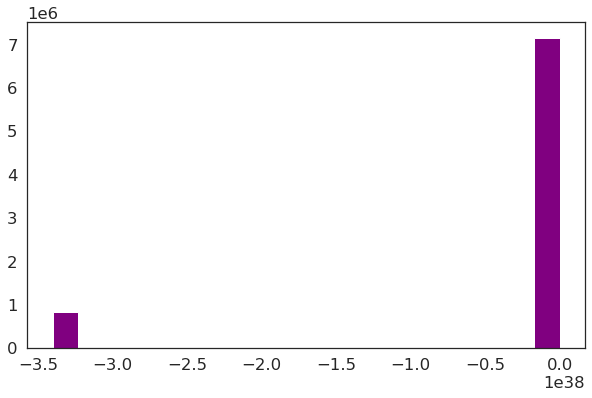

In [20]:
print("the minimum raster value is: ", dtm_pre_arr.min())
print("the maximum raster value is: ", dtm_pre_arr.max())

# A histogram can also be helpful to look at the range of values in your data
# What do you notice about the histogram below?

ep.hist(dtm_pre_arr,
       figsize=(10,6))
plt.show()

Looking at the minimum value of the data, there are two things going on that need to be fixed:

* Check if there should be *nodata* values in the data. *nodata* or invalid elements are pixels we would like to ignore when, for example, merging the image with another image. The negative value of the *nodata* elements might be skewing our plot colors.
* there also could be outlier data in our raster

We can explore the first option - that there are no data values by reading in the data and masking no data values using rasterio. To do this, we will use the `masked=True` parameter for the `.read()` function.

The type of the numpy array created in this way will be `numpy.ma.core.MaskedArray` since we are using to mask the *nodata* values in our data. Masking ensures that when we plot or perfomr arithmetic operations with the data, those *nodata* values are not included in the operation.  

the minimum raster value is:  1676.21
the maximum raster value is:  2087.43
Numpy Array Shape: (2000, 4000)
Object type: <class 'numpy.ma.core.MaskedArray'>


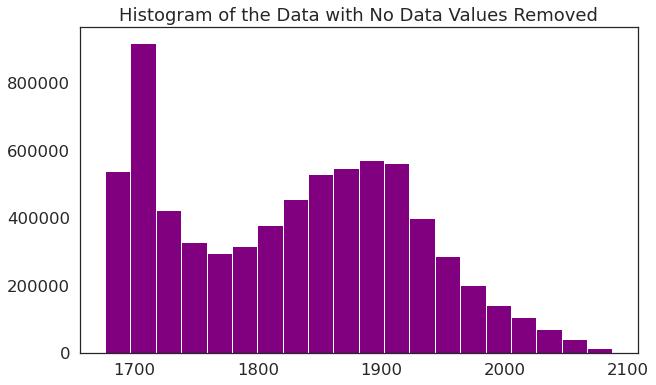

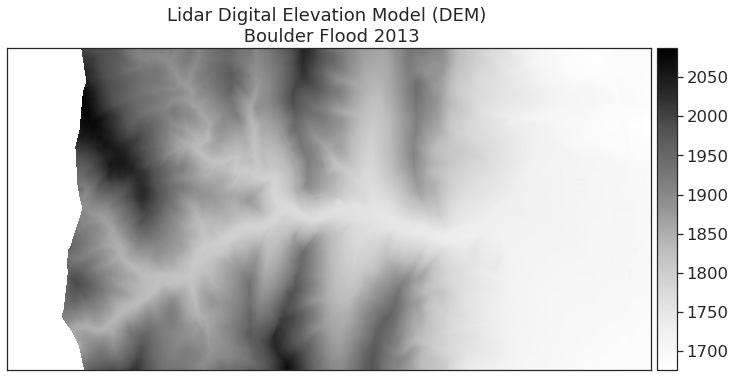

In [21]:
# Read in our data and mask the nodata values
with rio.open(dem_pre_path) as dem_src:
    # Masked=True will mask all nodata values
    dtm_pre_arr = dem_src.read(1, masked=True)


print("the minimum raster value is: ", dtm_pre_arr.min())
print("the maximum raster value is: ", dtm_pre_arr.max())

print("Numpy Array Shape:", dtm_pre_arr.shape)
print("Object type:", type(dtm_pre_arr))

# A histogram can also be helpful to look at the range of values in our data
ep.hist(lidar_dem_im,
       figsize=(10,6),
       title="Histogram of the Data with No Data Values Removed")
plt.show()

# Plot data using earthpy
ep.plot_bands(dtm_pre_arr,
              title="Lidar Digital Elevation Model (DEM) \n Boulder Flood 2013",
              cmap="Greys")

plt.show()

Now the minimum value is within the expected range. Plotting the data again displays what we were expecting.

### Spatial Metadata
A numpy array does not by default store spatial information. However, our raster data is spatial - it represents a location on the earth’s surface.

We can acccess the spatial metadata within the context manager using dem_src.profile. Notice that the .profile object contains information including the *nodata* values for our data, the shape the file type and even the coordinate reference system.

In [22]:
with rio.open(dem_pre_path) as dem_src:
    # lidar_dem_im = dem_src.read(1, masked=True)
    # Create an object called lidar_dem_meta that contains the spatial metadata
    lidar_dem_meta = dem_src.profile

lidar_dem_meta

{'driver': 'GTiff', 'dtype': 'float32', 'nodata': -3.4028234663852886e+38, 'width': 4000, 'height': 2000, 'count': 1, 'crs': CRS.from_epsg(32613), 'transform': Affine(1.0, 0.0, 472000.0,
       0.0, -1.0, 4436000.0), 'blockxsize': 128, 'blockysize': 128, 'tiled': True, 'compress': 'lzw', 'interleave': 'band'}

### Plot Raster and Vector Data Together

To plot raster and vector data together on a map, we will need to create an extent object that defines the spatial extent of our raster layer. This will then allow us to plot a raster and vector data together to create a map.

*Exercise* 
We will open a single shapefile that contains a boundary layer that we can overlay on top of our raster dataset.


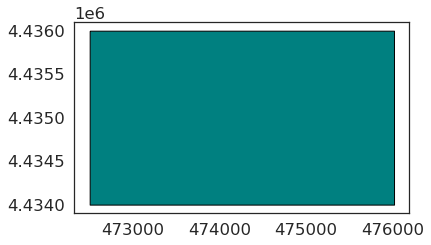

In [23]:
# Open site boundary vector layer
site_bound_path = os.path.join("data","colorado-flood",
                               "spatial",
                               "boulder-leehill-rd",
                               "clip-extent.shp")
site_bound_shp = gpd.read_file(site_bound_path)

# Plot the vector data
site_bound_shp.plot(color='teal',
                    edgecolor='black')
plt.show()

We could try to plot the two datasets together but, since the raster layer does not have spatial information associated with it, the output would look wrong.

In [24]:
# fig, ax = plt.subplots(figsize=(4,10))

# ep.plot_bands(dtm_pre_arr, ax=ax)

# site_bound_shp.plot(color='teal',
#                     edgecolor='black', ax=ax)

# plt.show()

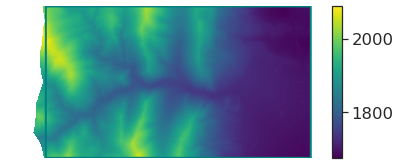

In [25]:
with rio.open(dem_pre_path) as dem_src:
    lidar_dem_im = dem_src.read(1, masked=True)
    # Create an object called lidar_dem_meta that contains the spatial metadata
    lidar_dem_plot_ext = plotting_extent(dem_src)

# This plotting extent object will be used below to ensure our data overlay correctly
lidar_dem_plot_ext

fig, ax = plt.subplots()

#the extent= parameter specifies the plotting extent within ep.plot_bands()
ep.plot_bands(dtm_pre_arr,
# lidar_dem_im,
              ax=ax,
              extent=lidar_dem_plot_ext,
              cmap = 'viridis')

site_bound_shp.plot(color='None',
                    edgecolor='teal',
                    linewidth=2,
                    ax=ax)
# Turn off the outline or axis border on your plot
ax.axis('off')
plt.show()

## Plot Raster Histograms
Histograms represent the distribution of the values in our data and is useful to:

1. Identify outlier data values
1. Assess the min and max values in our data
1. Explore the general distribution of values in the data - e.g. when exploring the distribution of pixel levation values, explore if the area generally flat, hilly, is it high elevation or low elevation.

What does a histogram tell us?

1. How the data is distributed. Each bar in the plot represents the number or frequency of pixels that fall within the range specified by the bin. we can use the `bins=` argument to change the number of breaks in our histogram.
1. We couls also specify the individual break poit=nt to use
   * e.g. bins=[1600, 1800, 2000, 2100]
   

It is better to remove the `NaN` values before plotting a histogram. To do this we would:

1. flatten the data using `ravel()`
1. remove `NaN` values

Another option is to remove the `NaN` values using a mask as seen before.

(2000, 4000)
(8000000,)


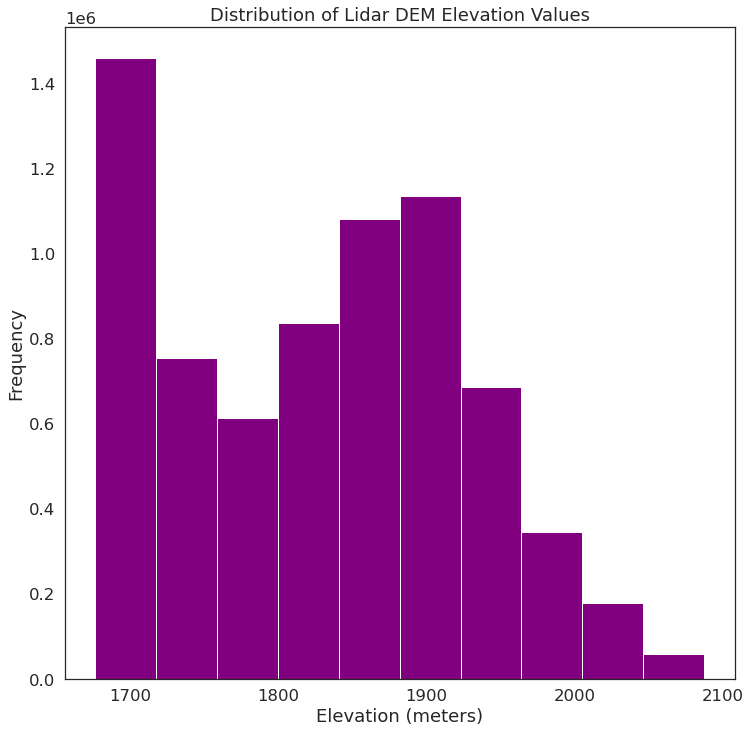

In [26]:
# Get data and set wd
et.data.get_data("colorado-flood")
os.chdir(os.path.join(et.io.HOME, 'earth-analytics'))

# Define relative path to file
lidar_dem_path = os.path.join("data", "colorado-flood", "spatial", 
                              "boulder-leehill-rd", "pre-flood", "lidar",
                              "pre_DTM.tif")

# Open data and assign negative values to nan
with rio.open(lidar_dem_path) as src:
    lidar_dem_im = src.read(1, masked=True)

# View object dimensions
print(lidar_dem_im.shape)

# The .ravel method turns an 2-D numpy array into a 1-D vector
print(lidar_dem_im.ravel().shape)

ep.hist(lidar_dem_im, colors=['purple'],
        title="Distribution of Lidar DEM Elevation Values",
        xlabel='Elevation (meters)',
        ylabel='Frequency',
        bins = 10)
plt.show()

## Raster Metadata

A Raster dataset has 3 main spatial attributes:

1. spatial extent
1. CRS
1. resolution

### CRS
CRS locates the raster in a geographic space and specifies the mathematical method that should be used to "flatten" or project the raster in geographic space.




In [27]:
# Import necessary packages
import os
import matplotlib.pyplot as plt
import numpy as np
from shapely.geometry import Polygon, mapping
import rasterio as rio
from rasterio.mask import mask
from rasterio.plot import show

# Package created for the earth analytics program
import earthpy as et

# Get data and set working directory
et.data.get_data("colorado-flood")
os.chdir(os.path.join(et.io.HOME, 'earth-analytics'))

# Define relative path to file
lidar_dem_path = os.path.join("data", "colorado-flood", "spatial", 
                              "boulder-leehill-rd", "pre-flood", "lidar",
                              "pre_DTM.tif")

# View crs of raster imported with rasterio
with rio.open(lidar_dem_path) as src:
    print(src.crs)

# Assign crs to myCRS object
myCRS = src.crs

print("CRS.from_epsg: ", myCRS)

EPSG:32613
CRS.from_epsg:  EPSG:32613


In order to determine the metadata for a given EPSG code, we can convert the EPSG code into a Proj4 string with rasterio.

In [28]:
# Each key of the dictionary is an EPSG code
print(list(et.epsg.keys())[:10], "\n")

# You can convert to proj4 like so:
proj4 = et.epsg['32613']
print(proj4)

# Finally you can convert this into a rasterio CRS like so:
crs_proj4 = rio.crs.CRS.from_string(proj4)
crs_proj4

['29188', '26733', '24600', '32189', '4899', '29189', '26734', '7402', '26951', '29190'] 

+proj=utm +zone=13 +datum=WGS84 +units=m +no_defs


CRS.from_epsg(32613)

* +proj=utm The projection of the dataset. Our data is in Universal Transverse Mercator (UTM).
* +zone=18 The UTM projection divides up the world into zones, this element tells us which zone the data is in. Harvard Forest is in Zone 18.
* +datum=WGS84 The datum was used to define the center point of the projection. Our raster uses the WGS84 datum.
* +units=m This is the horizontal units that the data is in. Our units are meters.

### Spatial Extent

The extent is the geographic rectangular area that the raster data covers. If the data is not rectangular, the extent covers the extreme values or edges, and might cover portions where there are no data.

We can use the `.bounds` method to get the extent 



In [29]:
src.bounds

BoundingBox(left=472000.0, bottom=4434000.0, right=476000.0, top=4436000.0)

### Raster Resolution
resolution represents the area on the ground covered by each pixel in the units specified by the CRS. 

We can use the `.res` method to see the resolution 

In [30]:
# What is the x and y resolution for your raster data?
src.res

(1.0, 1.0)

## Geotiff (.tif) File Format

A GeoTIFF is a standard .tif or image file format that includes additional spatial (georeferencing) information embedded in the .tif file as tags called tif tags. These tags can include the following raster metadata:

* Spatial Extent: Area covered by the dataset
* Coordinate reference system: What spatial projection / coordinate reference system is used to store the data? Will it line up with other data?
* Resolution: What area on the ground does each pixel cover - i.e. What is its spatial resolution?
* nodata value: How is the *nodata* represented?
* How many layers are in the .tif file.
* mask associated with the data. values =0 are nodata values whereas = 255 are usable data values.
* data format

We can also extract or view individual metadata attributes.

With geotiffs, the spatial information that describes the raster data are embedded within the file itself.







In [31]:
# Import necessary packages
import os
import rasterio as rio
import earthpy as et

# Get data and set working directory
et.data.get_data("colorado-flood")
os.chdir(os.path.join(et.io.HOME, 'earth-analytics'))

# Define relative path to file
lidar_dem_path = os.path.join("data", "colorado-flood", "spatial", 
                              "boulder-leehill-rd", "pre-flood", "lidar",
                              "pre_DTM.tif")

with rio.open(lidar_dem_path) as lidar_dem:
    #extent
    lidar_dem.bounds
# spatial resolution?
lidar_dem.res

# View generate metadata associated with the raster file
lidar_dem.meta

print(lidar_dem.tags(ns='IMAGE_STRUCTURE'))

# View image structure
with rio.open(lidar_dem_path) as lidar_dem:
    print(lidar_dem.tags(ns='IMAGE_STRUCTURE'))
    lidar_dem_mask = lidar_dem.dataset_mask()

# View data mask
print(lidar_dem_mask)

{}
{'COMPRESSION': 'LZW', 'INTERLEAVE': 'BAND'}
[[  0   0   0 ... 255 255 255]
 [  0   0   0 ... 255 255 255]
 [  0   0   0 ... 255 255 255]
 ...
 [  0   0   0 ... 255 255 255]
 [  0   0   0 ... 255 255 255]
 [  0   0   0 ... 255 255 255]]


After extracting the metadata, we can perform tests on the data.

e.g. compare between two datasets

In [32]:
# Define relative path to file
lidar_dsm_path = os.path.join("data", "colorado-flood", "spatial", 
                              "boulder-leehill-rd", "pre-flood", "lidar",
                              "pre_DSM.tif")

# Open lidar dsm
with rio.open(lidar_dsm_path) as lidar_dsm:
    extent_lidar_dsm = lidar_dsm.bounds 

if lidar_dem.bounds == lidar_dsm.bounds:
    print("Both datasets cover the same spatial extent")

# Do both layers have the same spatial resolution?
if lidar_dsm.res == lidar_dem.res:
    print("Both datasets have the same resolution")


Both datasets cover the same spatial extent
Both datasets have the same resolution


### Single Layer (or Band) vs Multi-layer (Band Geotiffs)

We can see how many layers a raster object has by:
* using the `count()` function 
* seeing the `indexes` attribute


In [33]:
print(lidar_dem.count)

# How many bands / layers does the object have?
print("number of bands", lidar_dem.indexes)

1
number of bands (1,)


## Exercises

Challenge 1: Open And Plot Hillshade
It’s time to practice your raster skills. Do the following:

Use the pre_DTM_hill.tif layer in the colorado-flood/spatial/boulder-leehill-rd/pre-flood/lidar directory.

Open the pre_DTM_hill.tif layer using rasterio.
Plot the data using ep.plot_bands().
Set the colormap (cmap=) parameter value.
Give you plot a title.


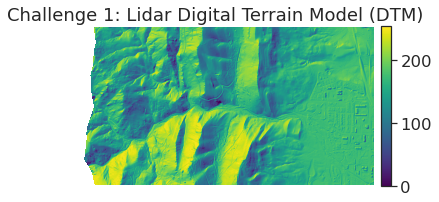

In [52]:
# Here
lidar_dsm_path = os.path.join("data", "colorado-flood", "spatial", 
                              "boulder-leehill-rd", "pre-flood", "lidar",
                              "pre_DTM_hill.tif")

# Open lidar dsm
with rio.open(lidar_dsm_path) as lidar_dsm:
    lidar_dem_im = lidar_dsm.read(1, masked=True) 

fig, ax = plt.subplots()

# ep.plot_bands()
ep.plot_bands(lidar_dem_im,
              ax=ax,
              extent=lidar_dem_plot_ext,
              cmap = 'viridis',
              title="Challenge 1: Lidar Digital Terrain Model (DTM)")

# Turn off the outline or axis border on your plot
ax.axis('off')
plt.show()

Challenge 2: Overlay DTM Over DTM Hillshade
In the challenge above, you opened and plotted a hillshade of the lidar digital terrain model create from NEON lidar data before the 2013 Colorado Flood. In this challenge, you will use the hillshade to create a map that looks more 3-dimensional by overlaying the DTM data on top of the hillshade.

To do this, you will need to plot each layer using ep.plot_bands()

1. Plot the hillshade layer pre_DTM_hill.tif that you opened in Challenge 1. Similar to Challenge one set cmap="Greys"
1. Plot the DTM that you opened above dtm_pre_arr
   * When you plot the DTM, use the alpha= parameter to adjust the opacity of the DTM so that you can see the shading on the hillshade underneath the DTM.
   * Set the colormap to viridis (or any colormap that you prefer) cmap='viridis' for the DTM layer.
HINT: be sure to use the ax= parameter to make sure both layers are on the same figure.

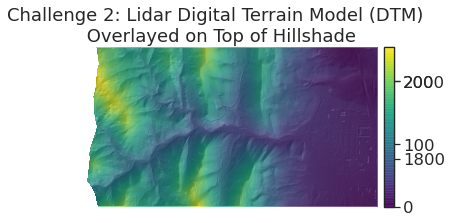

In [63]:
lidar_dsm_path = os.path.join("data", "colorado-flood", "spatial",
                              "boulder-leehill-rd", "pre-flood", 
                              "lidar",
                              "pre_DTM_hill.tif")

# Open lidar dsm
with rio.open(lidar_dsm_path) as lidar_dsm:
    lidar_dem_im = lidar_dsm.read(1, masked=True) 
    lidar_dem_im_plot_ext = plotting_extent(lidar_dsm)


# Define relative path to file
dem_pre_path = os.path.join("data","colorado-flood", "spatial",
                              "boulder-leehill-rd", "pre-flood",
                              "lidar",
                              "pre_DTM.tif")

# Open the file using a context manager ("with rio.open" statement)
with rio.open(dem_pre_path) as dem_src:
    dtm_pre_arr = dem_src.read(1, masked=True)
    dtm_pre_arr_plot_ext = plotting_extent(dem_src)



fig, ax = plt.subplots()

# ep.plot_bands() lidar_dem_im
ep.plot_bands(lidar_dem_im,
              ax=ax,
              extent=lidar_dem_im_plot_ext,
              cmap = 'gray_r')

#   ep.plot_bands() lidar_dem_im
ep.plot_bands(dtm_pre_arr,
              ax=ax,
              extent=dtm_pre_arr_plot_ext,
              cmap = 'viridis',
              alpha = 0.7,
              title="Challenge 2: Lidar Digital Terrain Model (DTM) \n Overlayed on Top of Hillshade")

# Turn off the outline or axis border on your plot
ax.axis('off')
plt.show()



Challenge 3: Add A Site Boundary to Your Raster Plot
Take all of the code that you wrote above to plot the DTM on top of your hillshade layer. Add the site boundary layer that you opened above site_bound_shp to your plot.

HINT: remember that the plotting_extent() object (lidar_dem_plot_ext) will be needed to add this final layer to your plot.

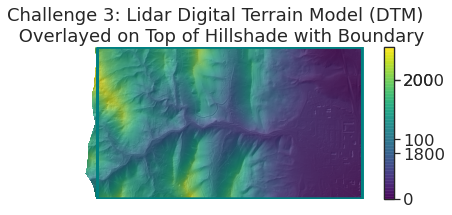

In [69]:
lidar_dsm_path = os.path.join("data", "colorado-flood", "spatial",
                              "boulder-leehill-rd", "pre-flood", 
                              "lidar",
                              "pre_DTM_hill.tif")

# Open lidar dsm
with rio.open(lidar_dsm_path) as lidar_dsm:
    lidar_dem_im = lidar_dsm.read(1, masked=True) 
    lidar_dem_im_plot_ext = plotting_extent(lidar_dsm)


# Define relative path to file
dem_pre_path = os.path.join("data","colorado-flood", "spatial",
                              "boulder-leehill-rd", "pre-flood",
                              "lidar",
                              "pre_DTM.tif")

# Open the file using a context manager ("with rio.open" statement)
with rio.open(dem_pre_path) as dem_src:
    dtm_pre_arr = dem_src.read(1, masked=True)
    dtm_pre_arr_plot_ext = plotting_extent(dem_src)


# Open site boundary vector layer
site_bound_path = os.path.join("data","colorado-flood",
                               "spatial",
                               "boulder-leehill-rd",
                               "clip-extent.shp")
site_bound_shp = gpd.read_file(site_bound_path)




fig, ax = plt.subplots()

# ep.plot_bands() lidar_dem_im
ep.plot_bands(lidar_dem_im,
              ax=ax,
              extent=lidar_dem_im_plot_ext,
              cmap = 'gray_r')

#   ep.plot_bands() lidar_dem_im
ep.plot_bands(dtm_pre_arr,
              ax=ax,
              extent=dtm_pre_arr_plot_ext,
              cmap = 'viridis',
              alpha = 0.7,
              title="Challenge 3: Lidar Digital Terrain Model (DTM) \n Overlayed on Top of Hillshade with Boundary")
              
site_bound_shp.plot(color='None',
                    edgecolor='teal',
                    linewidth=3,
                    ax=ax)


# Turn off the outline or axis border on your plot
ax.axis('off')
plt.show()

# Chapte 5: Processing Raster Data

In this chapter we will learn how to process raster data by cropping, reprojecting and reclassifying.


